# Write Neural Network from Scratch using Numpy
<br/><br/>

# Define Gates (Add, Multiply)

### Some Notations:
$$
WX + b = \mathbf{S} \\
\frac{\partial{L}}{\partial{WX}} = d(WX) \\
\frac{\partial{L}}{\partial{S}} = d({S}) \\
$$

Math: http://cs231n.github.io/optimization-2/

In [1]:
class Mul:
    def forward(self, W, X):
        return np.dot(X, W)
    
    def backward(self, W, X, dWX):
        dW = np.dot( np.transpose(X), dWX )
        dX = np.dot( dWX, np.transpose (W))
        return dW, dX

In [2]:
class Add:
    def forward(self, WX, b):
        return WX + b

    def backward(self, WX, b, dS):
        dWX = dS * np.ones_like(WX, dtype=np.float64)
        db = np.dot(np.ones((1, dS.shape[0]), dtype=np.float64), dS)
        return db, dWX

# Define Activaton Functions (ReLU, Sigmoid, Tanh, Softmax, etc.)

$$
Activation(S) = Z \\
Input: 
\frac{\partial{L}}{\partial{Z}} = d(Z) \\
Output:
\frac{\partial{L}}{\partial{S}} = d(S) \\
$$


In [3]:
class ReLU:
    def forward(self, S):
        Z = S * (S > 0)
        return Z
    
    def backward(self, S, dZ):
        dS = 1. * (S > 0) * dZ
        return dS

In [4]:
class Tanh:
    def forward(self, S):
        Z = np.tanh(S)
        return Z
    
    def backward(self, S, dZ):
        Z = self.forward(S)
        dS = (1.0 - np.square(Z)) * dZ
        return dS

In [5]:
class Sigmoid:
    def forward(self, S):
        Z = 1. / (1.0 + np.exp(-S))
        return Z
    
    def backward(self, S, dZ):
        Z = self.forward(S)
        dS =(1 - Z) * Z * dZ
        return dS

In [6]:
class  Softmax:
    # For Training
    def __init__(self):
        self.num_examples = 0
    
    def forward(self, S):
        self.num_examples = S.shape[0]
        exp_S = np.exp(S)
        Z = exp_S / np.sum(exp_S, axis = 1, keepdims = True)
        return Z

    def backward(self, S, y): # Note: y instead of dZ
        probs = Z = self.forward(S)
        for i in range(len(y)):
            true_label = y[i]
            probs[i][true_label] -= 1 # see equation above
        dS = probs
        return dS
    
    # For evaluation    
    def forward_loss(self, Z, y):
        probs = Z
        log_probs = []
        for prob, true_label in zip(probs, y):
            log_probs.append(np.log(prob[true_label]))
        avg_cross_entropy_loss = - 1. / self.num_examples * np.sum(log_probs) # see equation above
        return avg_cross_entropy_loss
    
    # For prediction
    def predict(self, Z):
        return np.argmax(Z, axis = 1)

$
for\ each\ sample\ i: 
$
$$
\hat{y_{k}} = softmax(S_1, S_2, ..., S_{k}),\ k\ is\ class\ index \\
\mathbf{E} = - \sum_{i=1}^N y_{ik} log(\hat{y_{ik}} )\\
\frac{\partial\mathbf{E}}{\partial S_{k}} = {\hat y}_{k} - y_{k},\ where\ y_{k} = 0, 1\\
$$

### Batch Normalization
- **Idea**: Normalize the inputs before activation function for each layer
- **Advantages**: 
    - Faster training;
    - Allow scale and shift

<img src="https://kratzert.github.io/images/bn_backpass/bn_algorithm.PNG" width="400">

In [7]:
class BatchNorm:
    def __init__(self):
        self.cache = ()
        
    def forward(self, X, gamma, beta, eps):
        num_examples = X.shape[0]
        
        mu_B = 1. / num_examples * np.sum(X, axis = 0)
        X_mu = X - mu_B
        var_B = 1. / num_examples * np.sum(  X_mu ** 2, axis = 0 )
        sqrt_var_B = np.sqrt(var_B + eps)
        i_sqrt_var_B = 1. / sqrt_var_B
        X_hat =  X_mu * i_sqrt_var_B
        gammaX = gamma * X_hat
        DZ = gammaX + beta
        
        self.cache = (X_hat, X_mu, gamma, i_sqrt_var_B, sqrt_var_B, var_B, eps)
        return DZ
    
    def backward(self, dDZ):
        num_examples = dDZ.shape[0]
        X_hat, X_mu, gamma, i_sqrt_var_B, sqrt_var_B, var_B, eps = self.cache
        
        # scale and shift
        dbeta = np.sum(dDZ, axis = 0)
        dgammaX = dDZ
        dgamma = np.sum(dgammaX * X_hat, axis = 0)
        dXhat = dgammaX * gamma
        
        # Standardize
        di_sqrt_var_B = np.sum(dXhat * X_mu, axis = 0)
        d_x_mu_2 = dXhat * i_sqrt_var_B
        dsqrt_var_B = -1. / (sqrt_var_B ** 2) * di_sqrt_var_B
        dvar_B = 0.5 * 1. / np.sqrt(var_B + eps) * dsqrt_var_B

        # Batch variance
        dsquare = 1. / num_examples * np.ones_like(dDZ) * dvar_B
        d_x_mu_1 = 2 * X_mu * dsquare
        
        # Batch mean
        d_x_mu = d_x_mu_2 + d_x_mu_1 # d(f(x)g(x)) = f(x)g'(x) = f'(x)g(x)
        dmu = -1. * np.sum(d_x_mu, axis = 0)
        dx_2 = d_x_mu
        dx_1 = 1. / num_examples * np.ones_like(dDZ) * dmu
        dx = dx_2 + dx_1
        
        return dx, dgamma, dbeta

# Define Optimizer

### Note 1: Weights Initialization
- **All zero**: wrong: neuron outputs and gradients would be same; same update
- **Number to small**: small gradients for inputs; gradient diminishing for deep NN
- **Preferred: All neuron with same output distribution**: 
    - w = np.random.randn(n) / sqrt(n), where n is number of inputs. 
    - It can be proved that Var(S) = Var(WX) = Var(X)

### Note 2: Param Update and Learning Rate

- Step decay: Reduce the learning rate by some factor every few epochs. Other approaches also avalable, like exponential decay, 1/t decay, etc.
- Second-order method, not common
- Per-parameter adaptive learning rate methods: Adagrad, Adam

<img src="http://cs231n.github.io/assets/nn3/nesterov.jpeg" width="600">

In [8]:
# Treat all elements of dX as a whole
#  Intuition: 
#  If gradient direction not changed, increase update, faster convergence
#  If gradient direction changed, reduce update, reduce oscillation

def VanillaUpdate(x, dx, learning_rate):
    x += -learning_rate * dx
    return x

def MomentumUpdate(x, dx, v, learning_rate, mu):
    v = mu * v - learning_rate * dx # integrate velocity, mu's typical value is about 0.9
    x += v # integrate position     
    return x, v

In [9]:
# Treat each element of dX adaptively
# Intuition:
# 1. Those dx receiving infrequent updates should have higher learning rate. vice versa 
# 2. We don't want: the gradients accumulate, and the learning rate monotically decrease, 
# 2. We want: modulates the learning rate of each weight based on the magnitudes of its gradient
# 3. Still want to use "momentum-like" update to get a smooth gradient

# 1. AdaGrad
def AdaGrad(x, dx, learning_rate, cache, eps):
    cache += dx**2
    x += - learning_rate * dx / (np.sqrt(cache) + eps) # (usually set somewhere in range from 1e-4 to 1e-8)
    return x, cache
    
# 1+2. RMSprop
def RMSprop(x, dx, learning_rate, cache, eps, decay_rate): #Here, decay_rate typical values are [0.9, 0.99, 0.999]
    cache = decay_rate * cache + (1 - decay_rate) * dx**2
    x += - learning_rate * dx / (np.sqrt(cache) + eps)
    return x, cache
    
# 1+2+3. Adam
def Adam(x, dx, learning_rate, m, v, t, beta1, beta2, eps):
    m = beta1*m + (1-beta1)*dx # Smooth gradient
    #mt = m / (1-beta1**t) # bias-correction step
    v = beta2*v + (1-beta2)*(dx**2) # keep track of past updates
    #vt = v / (1-beta2**t) # bias-correction step
    x += - learning_rate * m / (np.sqrt(v) + eps) # eps = 1e-8, beta1 = 0.9, beta2 = 0.999   
    return x, m, v

In [10]:
class WeightUpdate:
    def __init__(self, init_value):
        self.val = init_value
        self.cache = np.zeros_like(self.val, dtype=np.float64)
        self.m = np.zeros_like(self.val, dtype=np.float64)
        self.v = np.zeros_like(self.val, dtype=np.float64)
        self.t = 0
    
    def Update(self, d, learning_rate, lambda_ , method):
        
        old_val = self.val
        if method == 'Vanilla':
            self.val = VanillaUpdate(self.val, d, learning_rate)
        elif method == 'MomentumUpdate':
            self.val, self.v = MomentumUpdate(self.val, d, self.v, learning_rate, mu = 0.9)
        elif method == 'AdaGrad':
            self.val, self.cache = AdaGrad(self.val, d, learning_rate, self.cache, eps = 1e-5)
        elif method == 'RMSprop':
            self.val, self.cache = AdaGrad(self.val, d, learning_rate, self.cache, eps = 1e-5, decay_rate = 0.99)
        elif method == 'Adam':
            self.val, self.m, self.v = Adam(self.val, d, learning_rate, self.m, self.v, self.t, beta1 = 0.9, beta2 = 0.999, eps = 1e-8)  
            self.t += 1
            
        # Regularization
        self.val -= lambda_ * old_val
        return self.val

# 4. Define Layer

In [11]:
class Layer:
    def __init__(self, activation_function, num_neurons, batch_norm = False, dropout_p = 1.0):
        self.dim = num_neurons
        self.activation = activation_function
        self.batch_norm = batch_norm
        if batch_norm:
            self.batchnorm = BatchNorm()
        self.isfirst = False
        self.islast = False
        self.before = None
        self.p = dropout_p

    def set_first_layer(self, input):
        self.isfirst = True
        self.X = input
        
    def set_last_layer(self, y):
        self.islast = True
        self.y = y
    
    def initialize_Wb(self):
        if self.isfirst:
            before_dim = self.X.shape[1]
        else:
            before_dim = self.before.dim
        self.W = np.random.randn(before_dim, self.dim) / np.sqrt(before_dim) # see notes above
        self.b = np.random.randn(self.dim).reshape(1, self.dim) # see notes above
        self.gamma, self.beta = (1., 0.)

    def forward_propagation(self):
        if not self.isfirst:
            self.X = self.before.Z
            
        self.mask = np.random.rand(*self.W.shape) < self.p / self.p
        self.W *= self.mask
        self.WX = Mul().forward( self.W, self.X )
        self.S = Add().forward( self.WX, self.b)
        if self.batch_norm:
            self.SZ = self.batchnorm.forward( self.S, self.gamma, self.beta, eps = 0)
        else:
            self.SZ = self.S
        self.Z = self.activation.forward(self.SZ)
            
    def backward_propagation(self):
        if self.islast:
            self.dZ = self.y
        
        self.dSZ = self.activation.backward(self.SZ, self.dZ)
        if self.batch_norm:
            self.dS, self.dgamma, self.dbeta = self.batchnorm.backward(self.dSZ)
        else:
            self.dS = self.dSZ
            self.dgamma, self.dbeta = 0,0
        self.db, self.dWX = Add().backward(self.WX, self.b, self.dS)
        self.dW, self.dX = Mul().backward(self.W, self.X, self.dWX)
        self.dW *= self.mask
        
        if not self.isfirst:
            self.before.dZ = self.dX
    
    def update_weight(self, learning_rate, lambda_ , method):
        
        # Create variable list
        self.weights = [self.W, self.b, self.gamma, self.beta]
        self.ds = [self.dW, self.db, self.dgamma, self.dbeta]

        # First Time
        if not hasattr(self, 'updates'):      
            self.updates = []
            for weight in self.weights:
                self.updates.append(WeightUpdate(weight))
        
        # Calculate update for each iteration
        new_weights = []
        for weight_update, d in zip(self.updates, self.ds):
            new_weights.append(weight_update.Update(d, learning_rate, lambda_, method))
        
        # Update weights
        self.W, self.b, self.gamma, self.beta = new_weights
        
        #self.W += -learning_rate * self.dW + (- lambda_ * self.W)
        #self.b += -learning_rate * self.db
        #self.gamma += -learning_rate * self.dgamma
        #self.beta  += -learning_rate * self.dbeta
            
    # Only for softmax layer
    def calculate_loss(self):
        loss = self.activation.forward_loss(self.Z, self.y)
        return loss
            
    def predict(self):
        return self.activation.predict(self.Z)
    
    def calculate_acc(self): 
        pred = self.predict()
        return sum( pred == self.y ) / len(self.y)   

# Define Network

In [12]:
class Network:
    def __init__(self):
        self.layers = []
        self.input = []
        self.y = []
        
    def add(self, new_layer):
        if self.layers:
            new_layer.before = self.layers[-1]
        self.layers.append(new_layer)
    
    def load_data(self, input, y):
        self.layers[0].set_first_layer(input)
        self.layers[-1].set_last_layer(y)
        
    def initialize(self, input, y, batch_size):
        self.input = input
        self.y = y
        self.load_data(input[:batch_size,:], y[:batch_size])
        for layer in layers:
            layer.initialize_Wb()

    def train(self, num_iter, learning_rate, batch_size, rand_, lambda_, optimizer = 'Vanilla', Val_X = None, Val_y = None, 
             CAL_STEP = 100, PRINT_STEP = 100):
        
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        
        for i in range(num_iter):    
            # Calculate batch index
            if not rand_:
                idx = list(range(self.input.shape[0]))
            else:
                idx = np.random.randint(self.input.shape[0], size = batch_size)
            
            self.load_data(self.input[idx,:], self.y[idx])
            
            # Forward Propagation
            for layer in self.layers:
                layer.forward_propagation()
                
            # Print Traing Acc/Loss
            if (i % CAL_STEP == 0):
                t_loss = layers[-1].calculate_loss()
                t_acc  = layers[-1].calculate_acc()
                train_loss.append(t_loss)
                train_acc.append(t_acc)
                
            if (i % PRINT_STEP == 0):
                print('The Training Loss at Iteration ', i, ' is: ' , t_loss, ', Accuracy is', t_acc)
                
            # Backward Propagation
            for layer in self.layers[::-1]:
                layer.backward_propagation()
                layer.update_weight(learning_rate, lambda_ = lambda_ , method = optimizer)
            
            # Print Validation Acc/Loss
            if (i % CAL_STEP == 0 and Val_X is not None):
                v_acc, v_loss = self.evaluate(Val_X, Val_y)
                val_loss.append(v_loss)
                val_acc.append(v_acc) 
                
            if (i % PRINT_STEP == 0 and Val_X is not None):
                print('The Validation Loss at Iteration ', i, ' is: ' , v_loss, ', Accuracy is', v_acc)

        # Finally return loss list
        return train_loss, train_acc, val_loss, val_acc
    
    def predict(self, X):
        self.load_data(X, y = None)
        for layer in self.layers:
            layer.forward_propagation()
        return layers[-1].predict()
        
    def evaluate(self, X, y):
        self.load_data(X, y)
        for layer in self.layers:
            layer.forward_propagation()
        loss = layers[-1].calculate_loss()
        acc  = layers[-1].calculate_acc()
        return acc, loss

<br/>
# Generate some dataset

In [13]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
%matplotlib inline

### Option 1: Simple dataset

In [14]:
X, y = make_moons(1000, noise = 0.1)
print(X.shape, y.shape)

(1000, 2) (1000,)


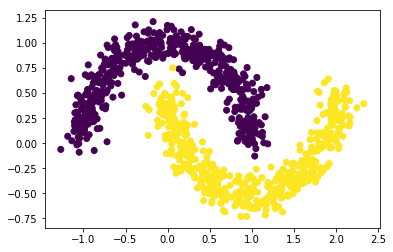

In [15]:
plt.scatter(X[:,0], X[:,1], c = y)

### Option 2: MNIST

In [ ]:
# Only using the dataset, not using any function
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [17]:
X = mnist.train.images[:3000].astype(np.float64)
y = np.array([ np.where(r==1)[0][0] for r in mnist.train.labels[:3000]], np.int32)
print(X.shape, y.shape)

(3000, 784) (3000,)


### Option 3: IRIS

In [14]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('./IRIS_data/iris_training.csv')
df2 = pd.read_csv('./IRIS_data/iris_test.csv')
df = pd.concat([df1,df2])
df = pd.concat([df,df, df])

In [15]:
X = np.array(df.iloc[:,:4])
X.shape

(450, 4)

In [16]:
y = np.array(df.iloc[:,-1])
y.shape

(450,)

## Split training, validation, test set

In [17]:
def train_test_split(X, y, test_size = 0.2, random_state = 42):
    import random
    num_examples = X.shape[0]
    inds = list(range(num_examples))
    test_ind  = random.sample(inds, int(test_size * num_examples))
    train_ind = [ind for ind in inds if ind not in test_ind]
    return X[train_ind,:], y[train_ind], X[test_ind,:], y[test_ind]

In [18]:
X_train_val, y_train_val, X_test, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, y_train, X_val, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(252, 4) (252,) (108, 4) (108,) (90, 4) (90,)


# Design Network

### Option 1: Simple Example

In [19]:
np.random.seed(5)
network = Network()
layers = []
layers.append(Layer(activation_function = Tanh(), num_neurons = 5))
layers.append(Layer(activation_function = Tanh(), num_neurons = 5))
layers.append(Layer(activation_function = Softmax(), num_neurons = 2))
for layer in layers:
    network.add(layer)

### Option 2: MNIST

In [20]:
network = Network()
layers = []
layers.append(Layer(activation_function = Tanh(), num_neurons = 20))
layers.append(Layer(activation_function = Softmax(), num_neurons = 10))
for layer in layers:
    network.add(layer)

### Option 3: IRIS

In [26]:
del network
network = Network()
layers = []
layers.append(Layer(activation_function = ReLU(), num_neurons = 10, batch_norm = True))
layers.append(Layer(activation_function = ReLU(), num_neurons = 10, batch_norm = True, dropout_p = 0.8))
layers.append(Layer(activation_function = Softmax(), num_neurons = 3, dropout_p = 0.8))
for layer in layers:
    network.add(layer)

<br/>
# Train network

### Training Parameters

In [27]:
batch_size = 252 # Batch size for gradient update 
num_iter = 500 # Number of iterations
learning_rate = 0.001 # Learning Rate
lambda_ = 0. # Regularization parameter

### Initialize and Train

In [28]:
network.initialize(input = X_train, y = y_train, batch_size = batch_size)
train_loss, train_acc, val_loss, val_acc = network.train(
                     num_iter = num_iter, 
                     learning_rate = learning_rate, 
                     batch_size = batch_size, 
                     rand_ = True, 
                     lambda_ = lambda_,
                     optimizer = 'Vanilla',
                     Val_X = X_val, 
                     Val_y = y_val,
                     CAL_STEP = 25, 
                     PRINT_STEP = 50
                     )

The Training Loss at Iteration  0  is:  1.21752937341 , Accuracy is 0.337301587302
The Validation Loss at Iteration  0  is:  0.838468358919 , Accuracy is 0.657407407407
The Training Loss at Iteration  50  is:  0.0466828838235 , Accuracy is 0.996031746032
The Validation Loss at Iteration  50  is:  0.0687612983355 , Accuracy is 0.981481481481
The Training Loss at Iteration  100  is:  0.0519215218298 , Accuracy is 0.996031746032
The Validation Loss at Iteration  100  is:  0.058587428388 , Accuracy is 0.981481481481
The Training Loss at Iteration  150  is:  0.0451795282251 , Accuracy is 0.988095238095
The Validation Loss at Iteration  150  is:  0.0509453102043 , Accuracy is 0.990740740741
The Training Loss at Iteration  200  is:  0.0181747965591 , Accuracy is 1.0
The Validation Loss at Iteration  200  is:  0.0566070949098 , Accuracy is 0.981481481481
The Training Loss at Iteration  250  is:  0.0330009657081 , Accuracy is 0.996031746032
The Validation Loss at Iteration  250  is:  0.04958237

# Result Evaluation

## Plot loss and accuracy

[Text(0,0.5,'Loss')]

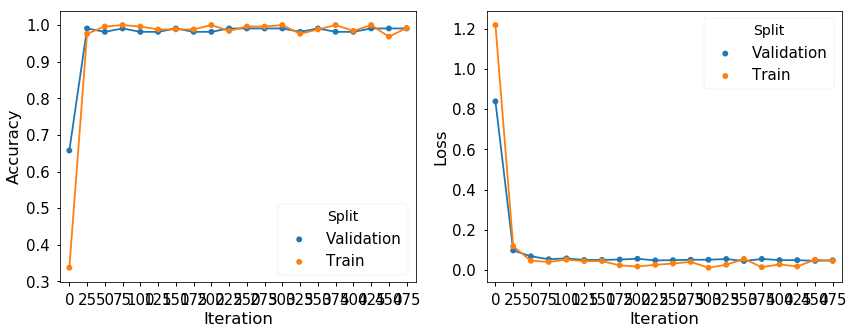

In [29]:
CAL_STEP = 25

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

df = pd.DataFrame(columns = ['Type','Iteration', 'Value'])
Values = train_loss, train_acc, val_loss, val_acc
Types = ['Loss', 'Accuracy', 'Loss', 'Accuracy']
Splits = ['Train', 'Train', 'Validation', 'Validation']

for Value, Type, Split in zip(Values, Types, Splits):
    dff = pd.DataFrame({'Type': Type,
                        'Split': Split,
                        'Iteration': list(range(num_iter))[::CAL_STEP],
                        'Value': Value})
    df = pd.concat([dff,df])

ax = sns.pointplot(x = 'Iteration', y = 'Value', markers='o', data = df[df.Type == 'Accuracy'], hue = 'Split', ax=axes[0])
ax.set( ylabel='Accuracy')
ax = sns.pointplot(x = 'Iteration', y = 'Value', markers='o', data = df[df.Type == 'Loss'], hue = 'Split', ax=axes[1])
ax.set( ylabel='Loss')

## Apply Model to Test Dateset

In [30]:
acc, loss = network.evaluate(X_test, y_test)
print('Accuracy on test dataset is: ', "%.4f" %acc)

Accuracy on test dataset is:  0.9778


## Visualize Decision Boundary for Simple Example

In [ ]:
from util.plots import plot_decision_boundary
%load_ext autoreload
%autoreload 2
plot_decision_boundary(lambda x: network.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()

## Gradient check

The purpose is to confirm that gradient calculation was correct

In [36]:
# Re-initialize network, with same X and y, fixed input, no weight update, no regularization
network.initialize(input = X, y = y, batch_size = batch_size)
network.train(num_iter = 500, learning_rate = 0., batch_size = batch_size, rand_ = False, lambda_ = 0.)

The Training Loss at Iteration  0  is:  1.11426502055 , Accuracy is 0.366666666667
The Training Loss at Iteration  100  is:  0.0353946108813 , Accuracy is 0.986666666667
The Training Loss at Iteration  200  is:  0.0353946108813 , Accuracy is 0.986666666667
The Training Loss at Iteration  300  is:  0.0353946108813 , Accuracy is 0.986666666667
The Training Loss at Iteration  400  is:  0.0353946108813 , Accuracy is 0.986666666667


([1.114265020553775,
  0.035394610881276593,
  0.035394610881276593,
  0.035394610881276593,
  0.035394610881276593],
 [0.36666666666666664,
  0.98666666666666669,
  0.98666666666666669,
  0.98666666666666669,
  0.98666666666666669],
 [],
 [])

Perturbate X[0,0] by +/- 1e5

In [37]:
X_plus = X.copy()
X_plus[0,0] += 1e-5
X_minus = X.copy()
X_minus[0,0] -= 1e-5

Calculate gradient

In [38]:
_, loss_plus = network.evaluate(X_plus, y)
_, loss_minus = network.evaluate(X_minus, y)
c_gradient = (loss_plus - loss_minus) / (2e-5) * X.shape[0]
print('Calculated Gradient: ', c_gradient)

Calculated Gradient:  -0.0325596989995


In [39]:
a_gradient = network.layers[0].dX[0,0]
print('Analytical Gradient: ' , a_gradient)

Analytical Gradient:  -0.0325596976046


In [40]:
print('Relative error: ', abs(c_gradient - a_gradient) / max(c_gradient, a_gradient))

Relative error:  -4.28410913345e-08


A better implementation will be checking gradients also at following steps, and for all parameters